<a href="https://colab.research.google.com/github/trilgar/MSM-2021/blob/main/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
from sklearn.metrics import mean_squared_error

In [77]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
epochs = 5

## Завантаження даних

In [78]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)
loader = DeviceDataLoader(loader, device)

# Звичайний автоенкодер

## Проектування моделі автоенкодера

In [79]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
			      torch.nn.Linear(18, 9)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
			      torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Tanh()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded,encoded

## Визначення функції втрат та оптимізатора

In [80]:
# Model Initialization
model = AE()
model.to(device)
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

## Навчання

Epoch [1/5], Step [500/1875], Loss: 0.0575
Epoch [1/5], Step [1000/1875], Loss: 0.0520
Epoch [1/5], Step [1500/1875], Loss: 0.0416
Loss for epoch =  0.04940904157757759


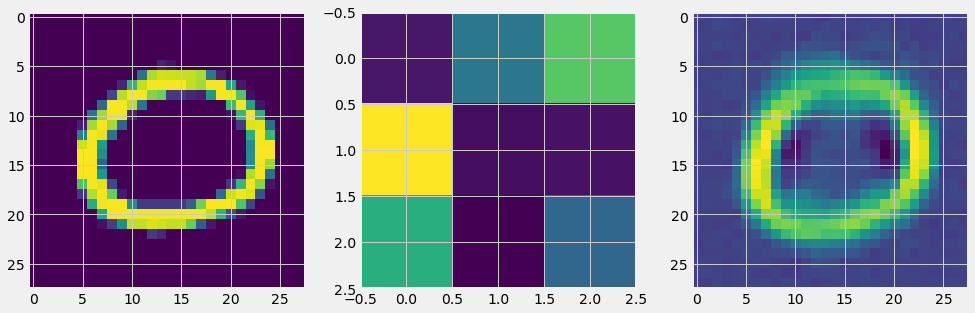

Epoch [2/5], Step [500/1875], Loss: 0.0421
Epoch [2/5], Step [1000/1875], Loss: 0.0377
Epoch [2/5], Step [1500/1875], Loss: 0.0331
Loss for epoch =  0.03734324309329192


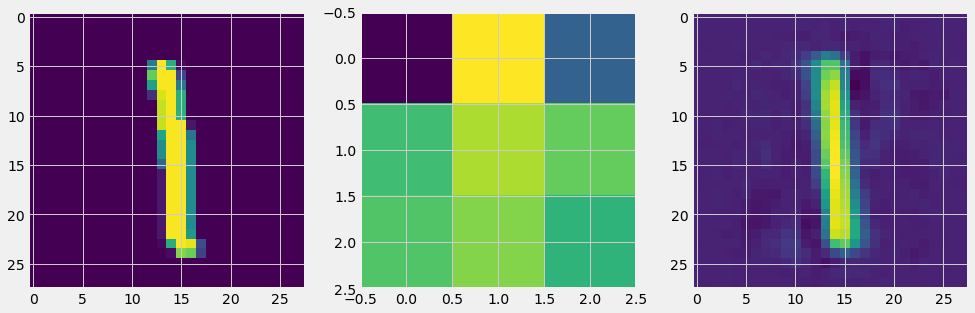

Epoch [3/5], Step [500/1875], Loss: 0.0326
Epoch [3/5], Step [1000/1875], Loss: 0.0293
Epoch [3/5], Step [1500/1875], Loss: 0.0261
Loss for epoch =  0.03201813725729783


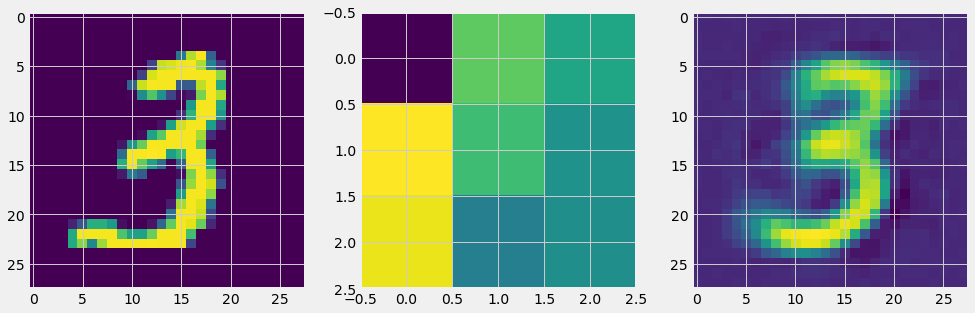

Epoch [4/5], Step [500/1875], Loss: 0.0329
Epoch [4/5], Step [1000/1875], Loss: 0.0313
Epoch [4/5], Step [1500/1875], Loss: 0.0309
Loss for epoch =  0.030189166679978372


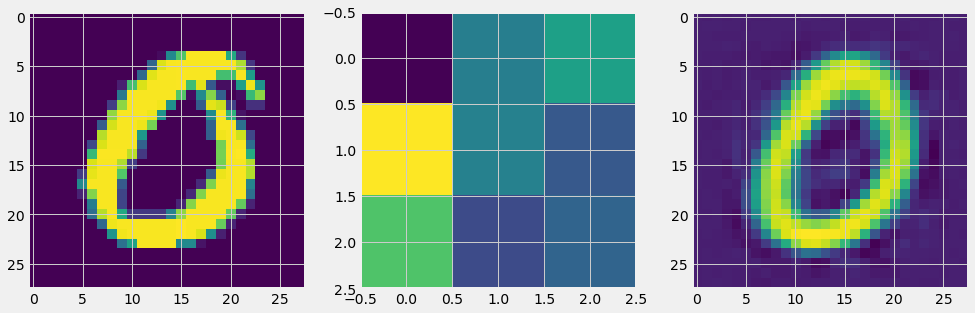

Epoch [5/5], Step [500/1875], Loss: 0.0268
Epoch [5/5], Step [1000/1875], Loss: 0.0313
Epoch [5/5], Step [1500/1875], Loss: 0.0240
Loss for epoch =  0.028490358427166938


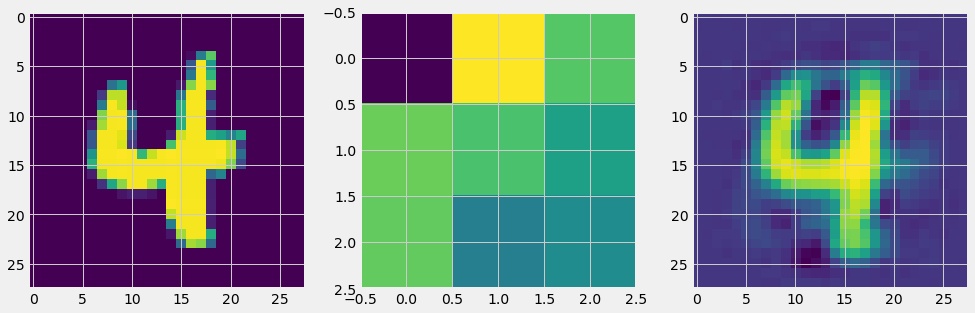

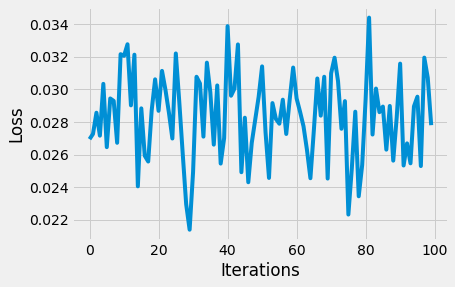

In [81]:
outputs = []
losses = []
total_step = len(loader)
for epoch in range(epochs):
    mse = []
    for i, (image, _) in enumerate(loader):
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28 * 28)

        # Output of Autoencoder
        reconstructed, encoded = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse.append(loss.item())
        # Storing the losses in a list for plotting
        losses.append(loss)
        if (i + 1) % 500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, i + 1, total_step, loss.item()))
    outputs.append((epochs, image, reconstructed))
    fig, (ax1,ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 8))
    enc = encoded[-1].cpu()
    rec = reconstructed[-1].cpu()
    ax1.imshow(image[-1].reshape(28,28).cpu())
    ax2.imshow(enc.reshape(3,3).detach().numpy())
    ax3.imshow(rec.reshape(28,28).detach().numpy())
    print('Loss for epoch = ', sum(mse)/len(mse))
    plt.show()

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])

## Збереження моделі

In [82]:
torch.save(model.state_dict(),'perceptron_autoencoder.ckpt')
model.eval()

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Tanh()
  )
)

## Демонстрація енкодингу та декодингу

In [83]:
MAE = {"mae_train": [], "mae_test": []}

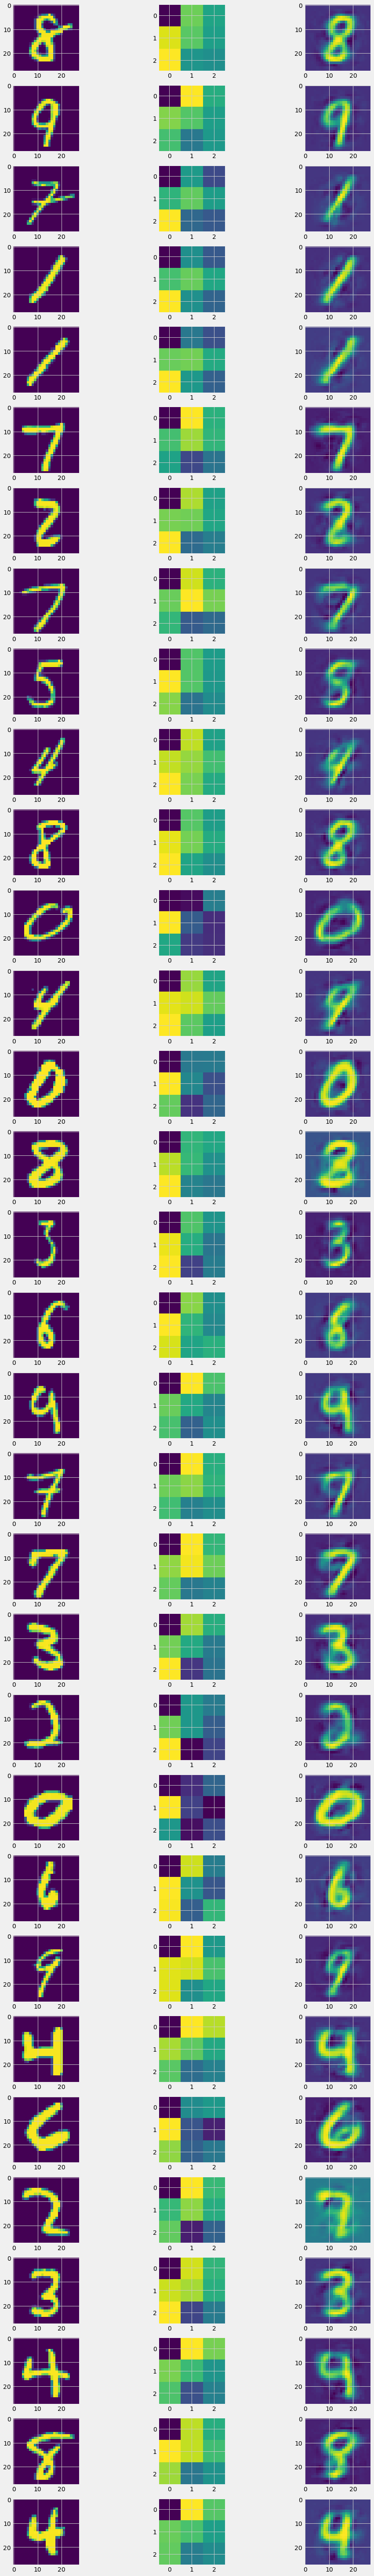

{'mae_test': [], 'mae_train': [0.02746148212463595]}

In [84]:
mae = []
fig, ax = plt.subplots(nrows = len(image), ncols = 3, figsize = (15, 100))
for i, item in enumerate(image):
  item = item.reshape(-1, 28, 28)
  ax[i,0].imshow(item[0].cpu())
  rec, enc = model(item.reshape(-1, 28 * 28))
  ax[i, 1].imshow(enc.reshape(3,3).cpu().detach().numpy())
  ax[i, 2].imshow(rec.reshape(28,28).cpu().detach().numpy())
  mae.append(mean_squared_error(item.reshape(-1, 28 * 28).cpu().detach().numpy(), rec.reshape(-1, 28 * 28).cpu().detach().numpy()))
MAE['mae_train'].append(sum(mae)/len(mae))
plt.show()
MAE

##  Тестування на власних числах написаних від руки

In [85]:
test_numbers = np.zeros((10, 28 ,28))
for i in range(0, 10):
  image = plt.imread("/content/drive/MyDrive/numbers datasets/"+str(i)+".png")
  test_numbers[i] = image
test_numbers = 1 - test_numbers

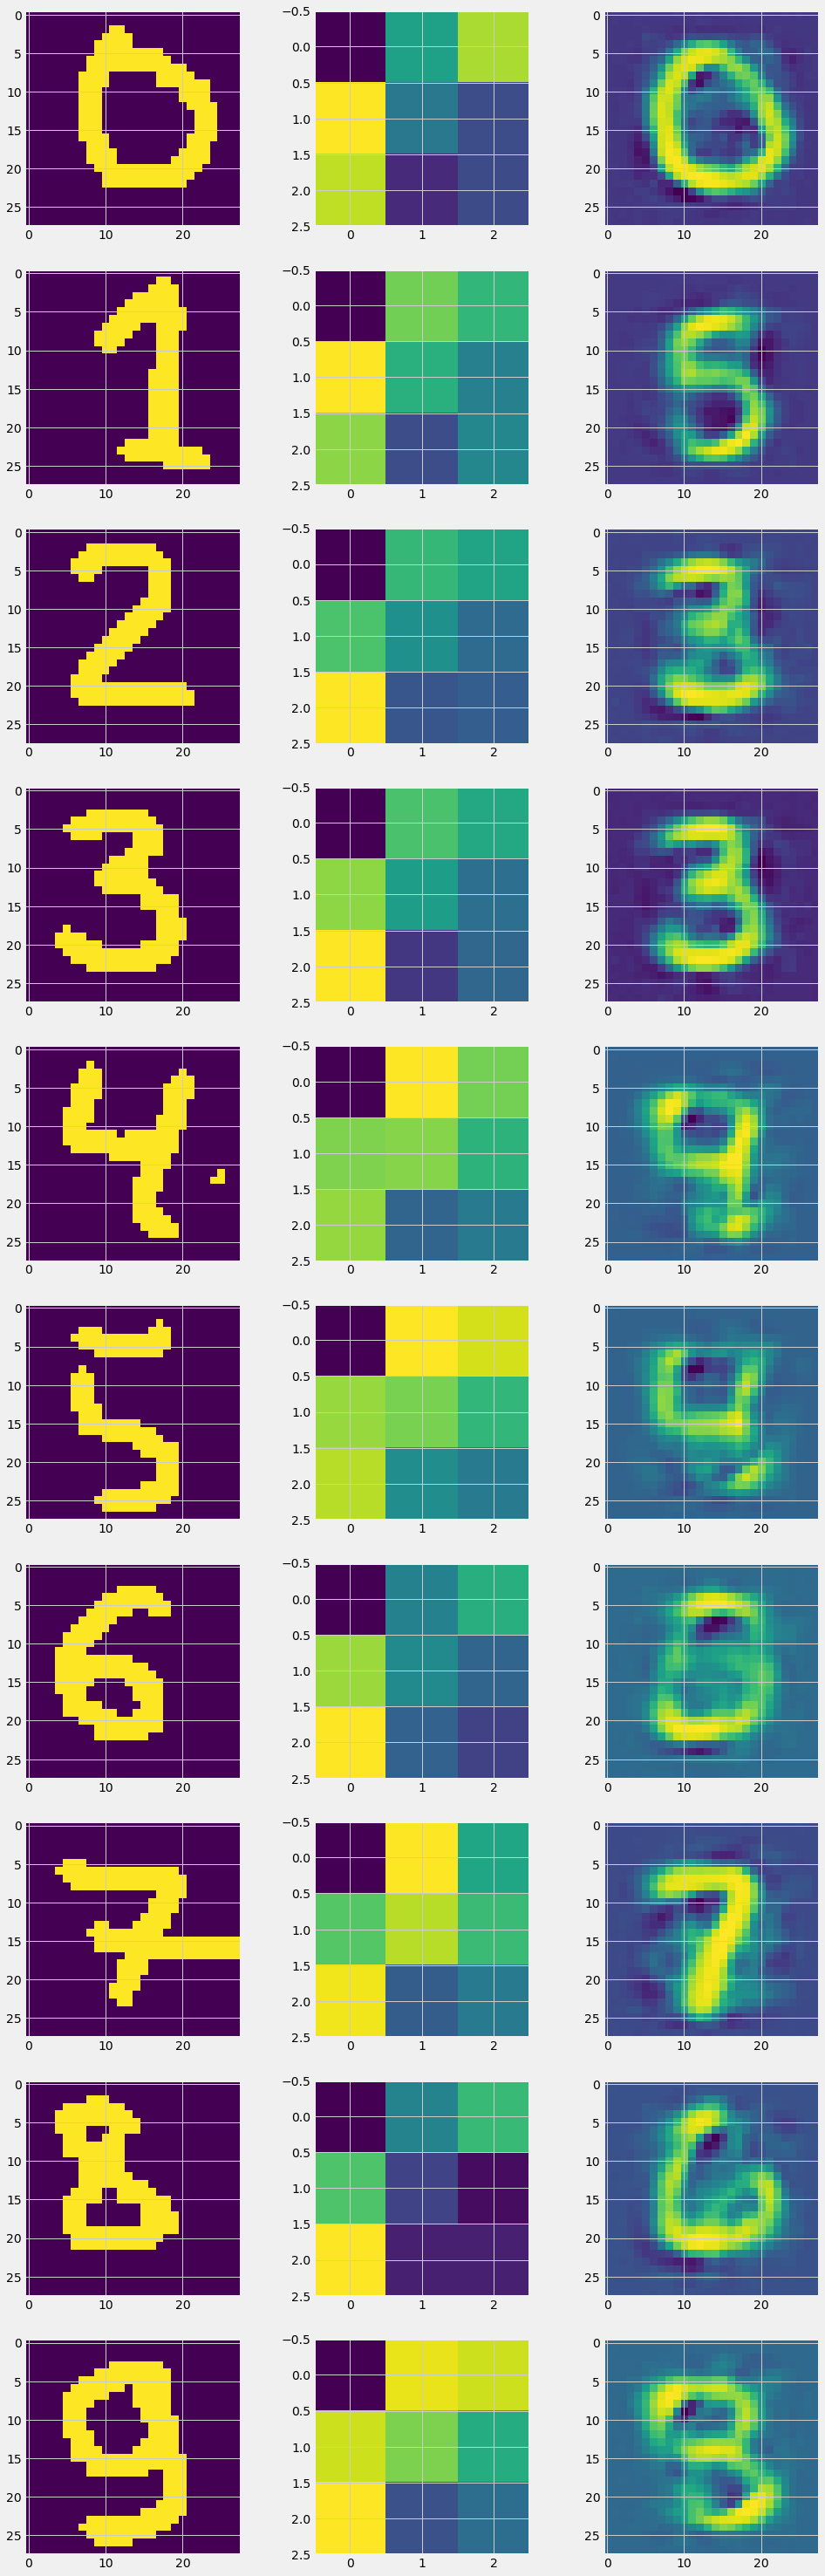

{'mae_test': [0.103481351928457], 'mae_train': [0.02746148212463595]}

In [86]:
fig, ax = plt.subplots(nrows = len(test_numbers), ncols = 3, figsize = (15, 50))
model = model.cpu()
mae = []
for i, item in enumerate(test_numbers):
  image = torch.tensor(item)
  ax[i,0].imshow(image)
  rec, enc = model(image.reshape(-1, 28*28).float())
  ax[i, 1].imshow(enc.reshape(3,3).cpu().detach().numpy())
  ax[i, 2].imshow(rec.reshape(28,28).cpu().detach().numpy())
  mae.append(mean_squared_error(item.reshape(-1, 28 * 28), rec.reshape(-1, 28 * 28).cpu().detach().numpy()))
MAE['mae_test'].append(sum(mae)/len(mae))
plt.show()
MAE

# Згортковий автоенкодер

## Проектування моделі

In [87]:
class AE_conv(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Flatten(start_dim=1),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, 9)
        )
        self.decoder = torch.nn.Sequential(
            nn.Linear(9, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

## Визначення функції втрат та оптимізатора

In [88]:
# Model Initialization
model = AE_conv()
model.to(device)
  
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-8)

## Навчання

Epoch [1/5], Step [500/1875], Loss: 0.0323
Epoch [1/5], Step [1000/1875], Loss: 0.0266
Epoch [1/5], Step [1500/1875], Loss: 0.0237
Loss for epoch =  0.03584524731040001


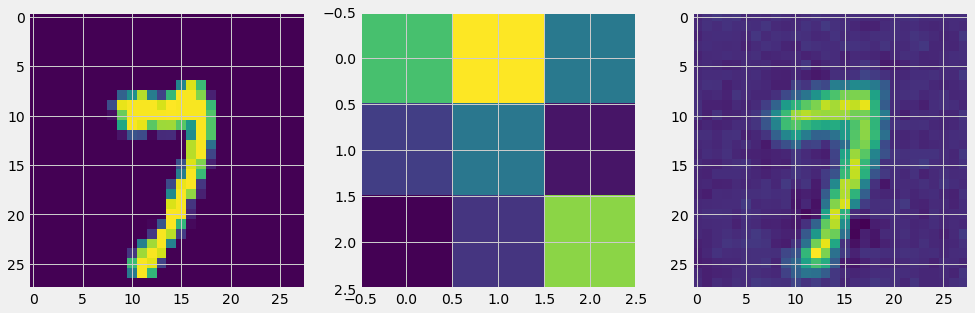

Epoch [2/5], Step [500/1875], Loss: 0.0193
Epoch [2/5], Step [1000/1875], Loss: 0.0209
Epoch [2/5], Step [1500/1875], Loss: 0.0201
Loss for epoch =  0.021496661909421285


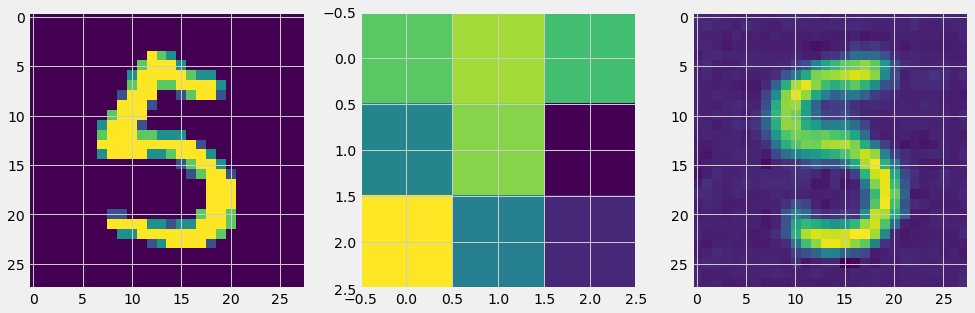

Epoch [3/5], Step [500/1875], Loss: 0.0212
Epoch [3/5], Step [1000/1875], Loss: 0.0192
Epoch [3/5], Step [1500/1875], Loss: 0.0189
Loss for epoch =  0.019261764795084794


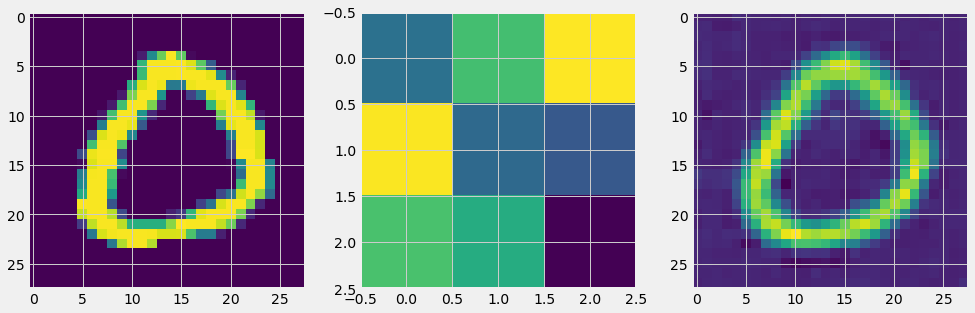

Epoch [4/5], Step [500/1875], Loss: 0.0160
Epoch [4/5], Step [1000/1875], Loss: 0.0166
Epoch [4/5], Step [1500/1875], Loss: 0.0153
Loss for epoch =  0.0180882705728213


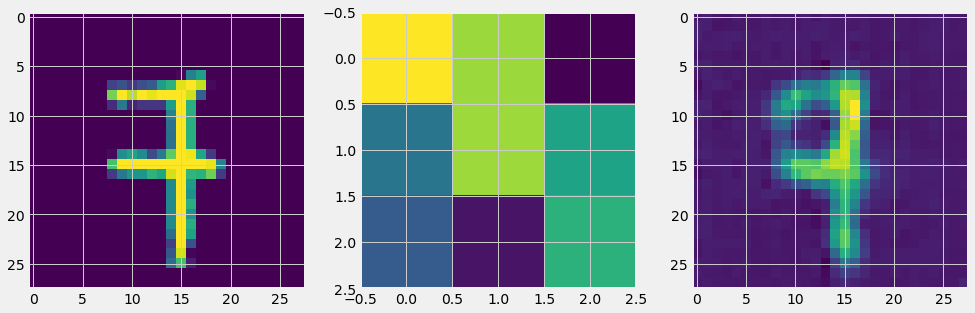

Epoch [5/5], Step [500/1875], Loss: 0.0153
Epoch [5/5], Step [1000/1875], Loss: 0.0178
Epoch [5/5], Step [1500/1875], Loss: 0.0164
Loss for epoch =  0.017381032084921994


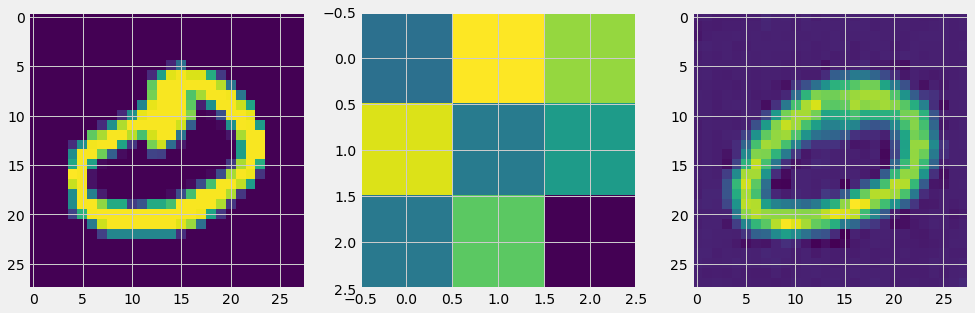

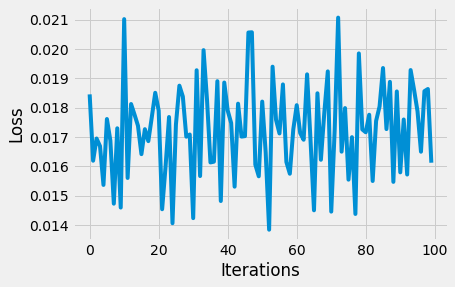

In [89]:
outputs = []
losses = []
total_step = len(loader)
for epoch in range(epochs):
    mse = []
    for i, (image, _) in enumerate(loader):
        # Output of Autoencoder
        reconstructed, encoded = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        mse.append(loss.item())
        # Storing the losses in a list for plotting
        losses.append(loss)
        if (i + 1) % 500 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, epochs, i + 1, total_step, loss.item()))
    outputs.append((epochs, image, reconstructed))
    fig, (ax1,ax2, ax3) = plt.subplots(ncols = 3, figsize = (15, 8))
    enc = encoded[-1].cpu()
    rec = reconstructed[-1].cpu()
    ax1.imshow(image[-1].reshape(28,28).cpu())
    ax2.imshow(enc.reshape(3,3).detach().numpy())
    ax3.imshow(rec.reshape(28,28).detach().numpy())
    print('Loss for epoch = ', sum(mse)/len(mse))
    plt.show()

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

losses = torch.tensor(losses, device='cpu')
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.show()

## Збереження моделі

In [90]:
torch.save(model.state_dict(),'convolutional_autoencoder.ckpt')
model.eval()

AE_conv(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=288, out_features=128, bias=True)
    (9): ReLU(inplace=True)
    (10): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, t

## Демонстрація енкодингу та декодингу

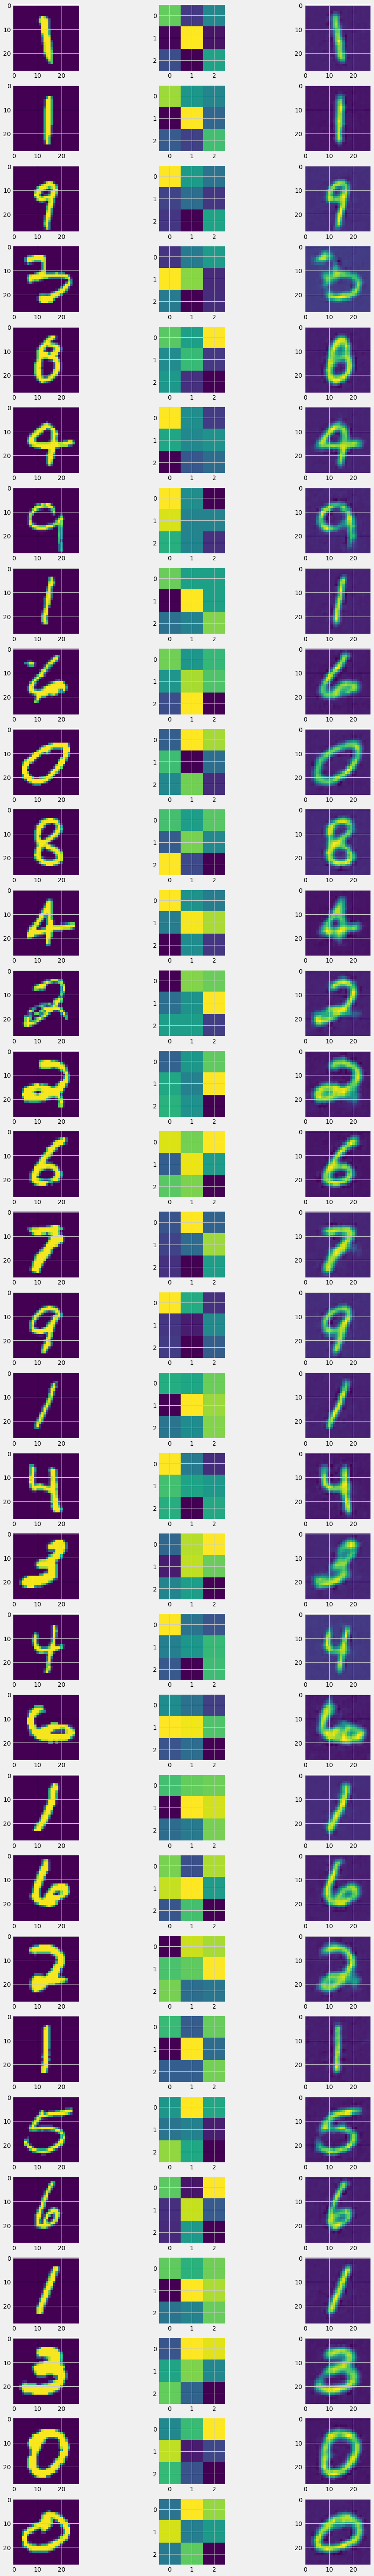

In [91]:
fig, ax = plt.subplots(nrows = len(image), ncols = 3, figsize = (15, 100))
mae = []
for i, item in enumerate(image):
  ax[i,0].imshow(item[0].cpu())
  item = item.unsqueeze(1)
  rec, enc = model(item)
  ax[i, 1].imshow(enc.reshape(3,3).cpu().detach().numpy())
  ax[i, 2].imshow(rec.reshape(28,28).cpu().detach().numpy())
  mae.append(mean_squared_error(item.reshape(-1, 28 * 28).cpu().detach().numpy(), rec.reshape(-1, 28 * 28).cpu().detach().numpy()))
MAE['mae_train'].append(sum(mae)/len(mae))
plt.show()

##  Тестування на власних числах написаних від руки

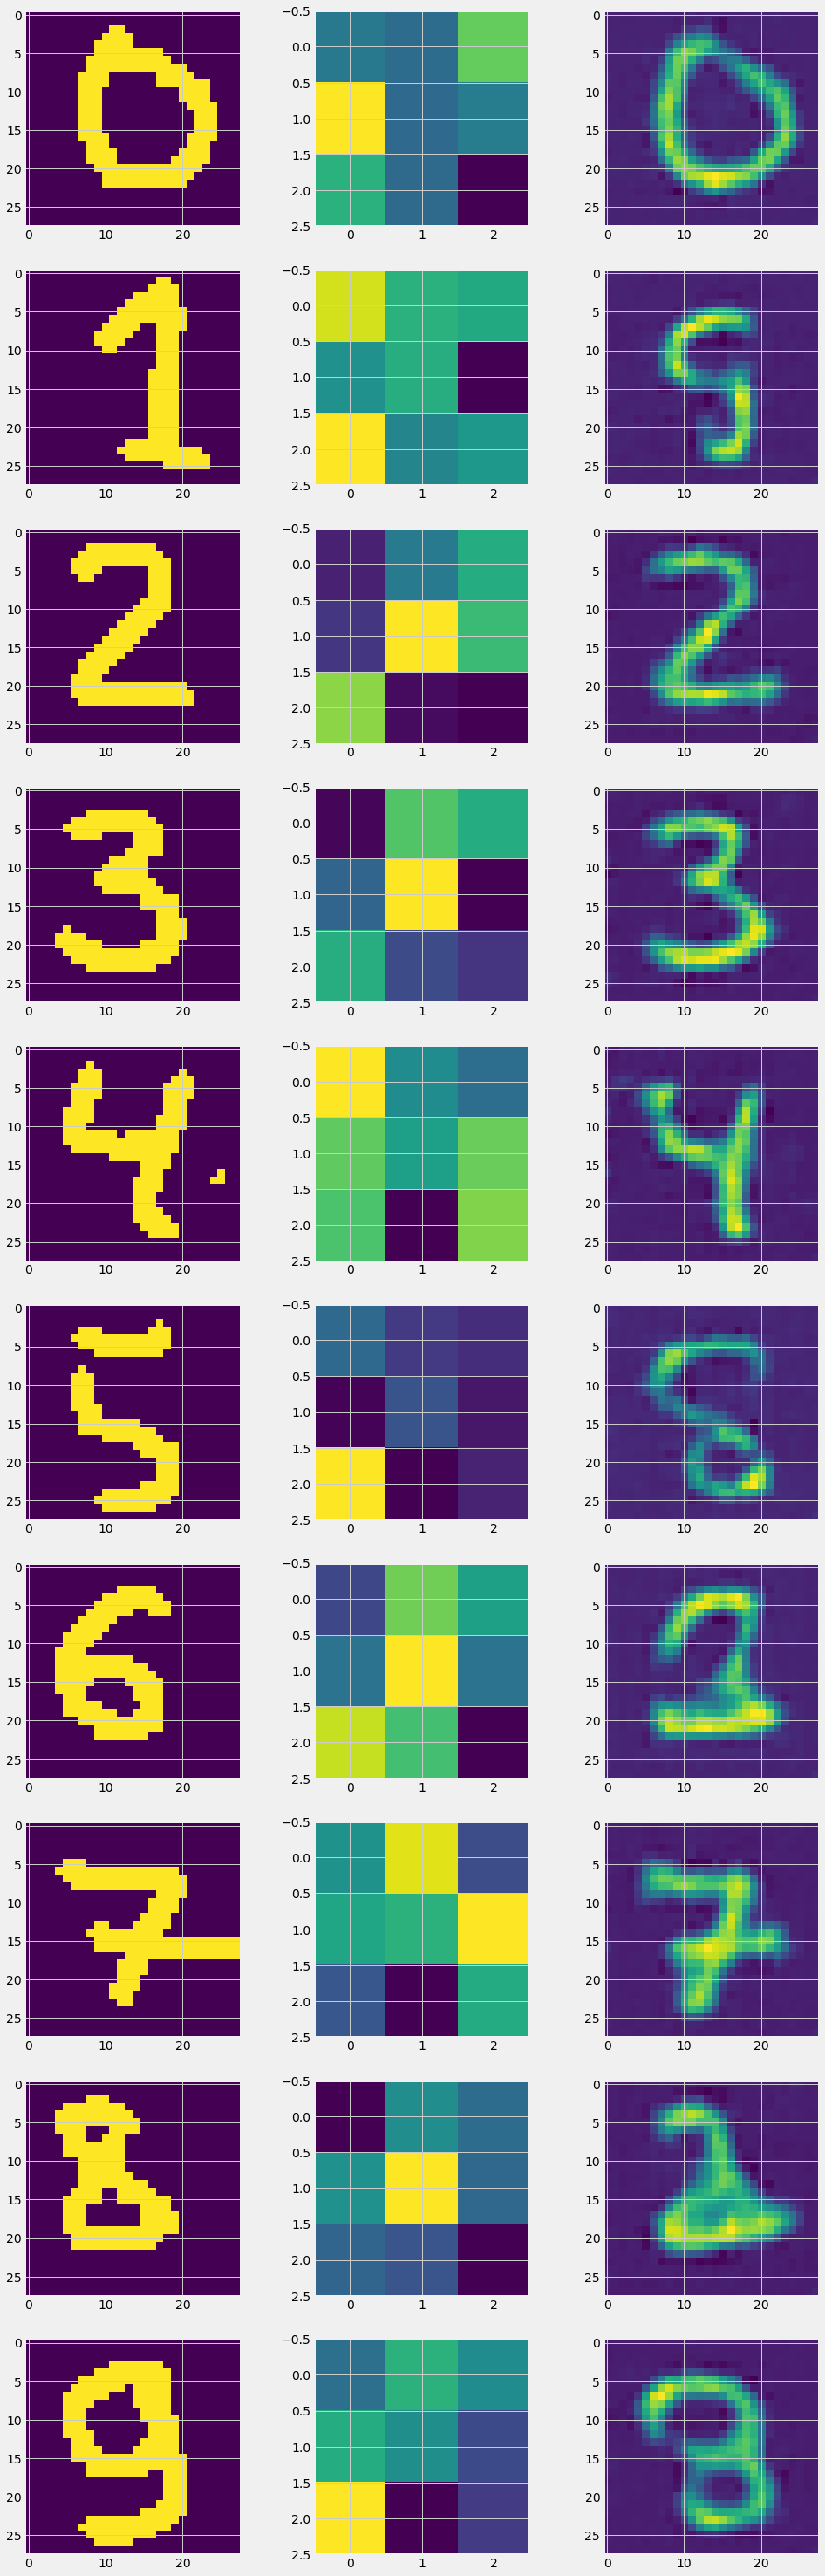

In [92]:
model = model.cpu()
mae = []
fig, ax = plt.subplots(nrows = len(test_numbers), ncols = 3, figsize = (15, 50))
for i, item in enumerate(test_numbers):
  image = torch.tensor(item)
  ax[i,0].imshow(image)
  image = image.unsqueeze(0)
  image = image.unsqueeze(0)
  rec, enc = model(image.float())
  ax[i, 1].imshow(enc.reshape(3,3).cpu().detach().numpy())
  ax[i, 2].imshow(rec.reshape(28,28).cpu().detach().numpy())
  mae.append(mean_squared_error(item.reshape(-1, 28 * 28), rec.reshape(-1, 28 * 28).cpu().detach().numpy()))
MAE['mae_test'].append(sum(mae)/len(mae))
plt.show()

In [93]:
MAE

{'mae_test': [0.103481351928457, 0.0901563461444414],
 'mae_train': [0.02746148212463595, 0.015532091223576572]}